# Example of the Harris Corner Detector "by scratch"

_External sources are marked and provided in the presentation_

## Importing libarys

- numpy       ->      matrices
- convolve2d  ->      matrix transforamtion
- pyplot      ->      plotting the matrices
- Pillow      ->      image libary

In [24]:
# no opencv used
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image

## Importing the image

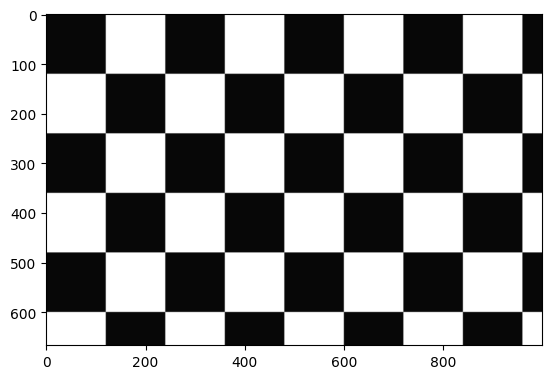

In [25]:
image_path = 'schach.jpg'
# open image and use grey scale mode (L)
original_image = np.array(Image.open(image_path).convert('L'))

# Debug
plt.imshow(original_image, cmap="grey")

## Step 1: Create the X and Y derivation matrices using the sobel filter

Sobel Kernel X: $$ Ix = \begin{bmatrix} -1 & 0 & 1  \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} $$

Sobel Kernel Y: $$ Iy = \begin{bmatrix} 1 & 2 & 1  \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} $$

More about [sobel kernels](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm
)

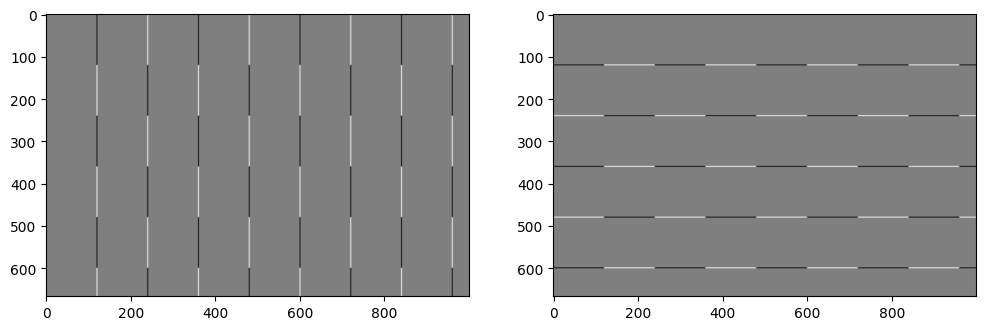

In [26]:
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# apply the sobel X and Y filter over the original image
# mode - same:      ouput size = input size of original image
# boundary - symm:  use pixels of other image border to calculate kernels at border
Ix = convolve2d(original_image, sobel_kernel_x, mode='same', boundary='symm')
Iy = convolve2d(original_image, sobel_kernel_y, mode='same', boundary='symm')

# Debug
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Ix, cmap="grey")
plt.subplot(1, 2, 2)
plt.imshow(Iy, cmap="grey")

## Step 2: Calculate the tensor

Now calculate the 3 fields of the tensor matrix

Tensor Formular
$$ E(u,v) = \begin{bmatrix} u & v \end{bmatrix} \sum\nolimits_{x,y} \begin{bmatrix} IxIx & IxIy \\IxIy & IyIy \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix} $$

In [27]:
IxIx = Ix * Ix
IyIy = Iy * Iy
IxIy = Ix * Iy

## Step 3: Calculate the squared gradient sum
Using the [scipy.signal.convolve2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) function to calculate the gradient sums for each pixel in specified window size

So Is_.. is are the summed window from the convolution

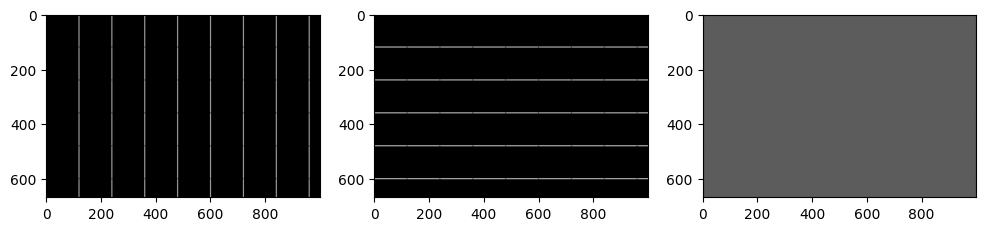

In [28]:
window_size=3 # size of the window where each pixel is calculated by the sum of the squared pixels
window_values = np.ones((window_size, window_size)) # could also be a Gaussian function 
Is_xx = convolve2d(IxIx, window_values, mode='same', boundary='symm')
Is_yy = convolve2d(IyIy, window_values, mode='same', boundary='symm')
Is_xy = convolve2d(IxIy, window_values, mode='same', boundary='symm')

# Debug
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(Is_xx, cmap="grey")
plt.subplot(1, 3, 2)
plt.imshow(Is_yy, cmap="grey")
plt.subplot(1, 3, 3)
plt.imshow(Is_xy, cmap="grey")

## Step 4: Compute the Harris corner response function
$$|R|=\text{det}(M) - k*(\text{trace}(M))^2$$

Note:
- 2x2 Determinante Calculation
$$\text{det}\begin{bmatrix} a & c \\ b & d \end{bmatrix} = ad - bc$$
- 2x2 Trace Calculation
$$\text{tr}\begin{bmatrix} a & b \\ c & d \end{bmatrix} = a + d$$

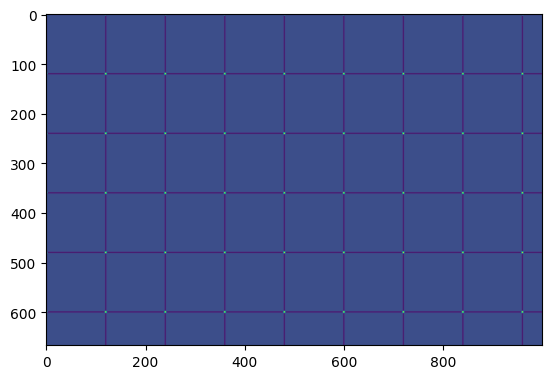

In [35]:
k=0.04 # common penalty parameters k => [0.04, 0.06]
detM = Is_xx * Is_yy - Is_xy **2
traceM = Is_xx + Is_yy
R = detM - k * (traceM **2)

# Debug
plt.imshow(R)

## Step 5: Thresholding


In [30]:
# creating a zero matrix with the size of out result matrix R
corners = np.zeros_like(R)

# treshold specifies at which magnitude the corners map pixel is declared as corner/edge
threshold=0.01
# set all values in the corners map to 1 for a value R being a corner
corners[R > threshold * R.max()] = 1

## Step 6: Show corners

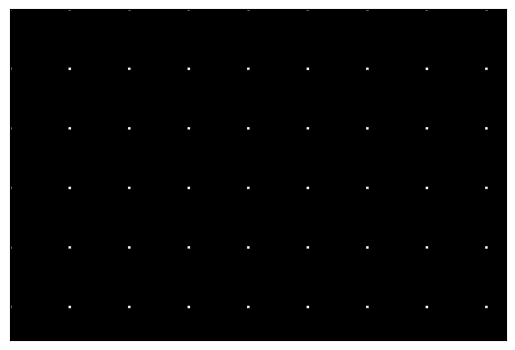

In [31]:
# remove legend from plot
plt.xticks([])
plt.yticks([])

plt.imshow(corners, cmap='gray') # corner uses gray-valued matrix

plt.show()

We can also search for edges by locking for differences between lambda1 and lambda2 like shown in image 
- ![[8]](https://docs.opencv.org/4.x/harris_region.jpg)

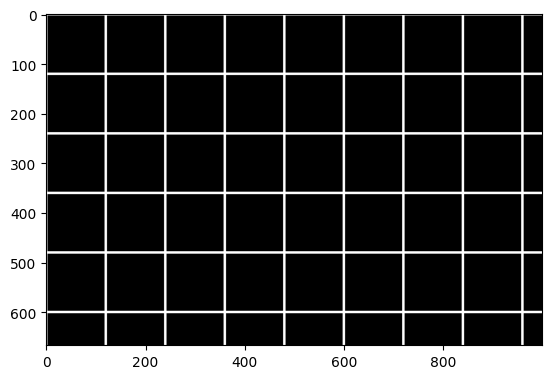

In [32]:
# calc the absolute difference, e.g. when lambda1 << lambda2 or lambda2 << lambda1

# second version (using the magnitude matrix R)
edges = np.zeros_like(R)
edges[traceM > threshold * traceM.max()] = 1
plt.imshow(edges, cmap="grey")

# first version (directly comparing the eigenvalues)
# diffIs = np.sqrt((Is_xx - Is_yy) ** 2) 
# plt.imshow(diffIs, cmap="grey")


# Example of the Harris Corner Detector with the OpenCV Implementation

OpenCV Harris Corner Example from [[8]](https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html)

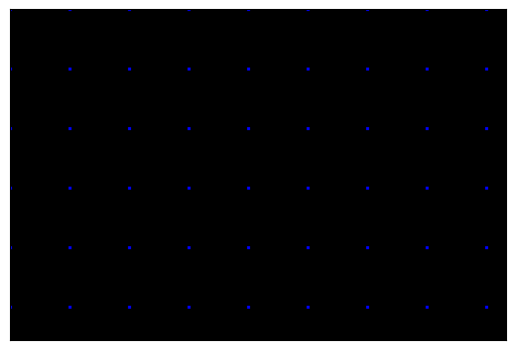

In [33]:
import cv2 as cv

img = cv.imread(image_path) # img path from aboth
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)

# remove scala from plot
plt.xticks([])
plt.yticks([])

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
img[dst<=0.01*dst.max()]=[0,0,0]
plt.imshow(img)
# plt.imshow(img)

Testing the result against the OpenCV implementation from OpenCV.com
